# Work on traffic_signs

In [215]:
# !pip install opencv-contrib-python
# !pip install numpy
# !pip install scikit-learn
# !pip install scikit-image
# !pip install imutils
# !pip install matplotlib
# !pip install tensorflow

In [216]:
base_path = "D:\GTSRB Dataset\gtsrb"
save_path = "./trafficsignnet.model"
plot_path = "./plot.png"
test_path = "./Test/"
example_path = "./examples"

In [222]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
class TrafficSignNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => BN => POOL
        model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
                  
        # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
                  
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
                  
        # second set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
                  
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
                  
        return model

In [228]:
import matplotlib
matplotlib.use("Agg")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import time

In [225]:
#function to load the dataset from the csv.
def load(basePath, csvPath):
    
    data = []
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    #shuffling rows to shuffle classes
    random.shuffle(rows)
    
    # loop over the rows
    for (i, row) in enumerate(rows):
        if i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))
       
        #split each row
        (label, imagePath) = row.strip().split(",")[-2:]
        
        #load each path
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)
        
        # resize the image to be 32x32 pixels and 
        # applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        data.append(image)
        labels.append(int(label))
        
    # convering to np array
    data = np.array(data)
    labels = np.array(labels)

    return (data, labels)

In [226]:
# derive training and testing CSV paths
trainPath = os.path.sep.join([base_path, "Train.csv"])
testPath = os.path.sep.join([base_path, "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load(base_path, trainPath)
(testX, testY) = load(base_path, testPath)

[INFO] loading training and testing data...
[INFO] processed 0 total images
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total imag

In [227]:
#setting parameters for training:
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

#this is an arbitary name file that was found with the dataset. 
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

#accounting for the skewed classes
classTotals = trainY.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [237]:
#data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# initialize and compiiling
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3,
        classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["accuracy"])

#early callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=5,
                                            restore_best_weights=True)

# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    callbacks=[callback],
    verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/30
612/612 [==============================] - 29s 46ms/step - loss: 7.7262 - accuracy: 0.1598 - val_loss: 2.8936 - val_accuracy: 0.1782
Epoch 2/30
612/612 [==============================] - 28s 46ms/step - loss: 4.4774 - accuracy: 0.3925 - val_loss: 1.1560 - val_accuracy: 0.6063
Epoch 3/30
612/612 [==============================] - 29s 47ms/step - loss: 3.1854 - accuracy: 0.5371 - val_loss: 1.1956 - val_accuracy: 0.5869
Epoch 4/30
612/612 [==============================] - 28s 47ms/step - loss: 2.3462 - accuracy: 0.6460 - val_loss: 0.5970 - val_accuracy: 0.8123
Epoch 5/30
612/612 [==============================] - 28s 46ms/step - loss: 1.8178 - accuracy: 0.7193 - val_loss: 0.5740 - val_accuracy: 0.8065
Epoch 6/30
612/612 [==============================] - 28s 46ms/step - loss: 1.4902 - accuracy: 0.7695 - val_loss: 0.6122 - val_accuracy: 0.7974
Epoch 7/30
612/612 [==============================] - 28s 45ms/step - loss: 1.2627 

In [238]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=labelNames))

# save the network
timestr = time.strftime("%Y%m%d-%H%M%S")
print("[INFO] serializing network to '{}.{}'...".format(save_path,timestr))
# save_path = os.path.sep.join(save_path,)
model.save(os.path.sep.join([save_path,timestr]))

[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.75      0.92      0.83        60
                              Speed limit (30km/h)       0.93      0.95      0.94       720
                              Speed limit (50km/h)       0.94      0.91      0.92       750
                              Speed limit (60km/h)       0.91      0.92      0.91       450
                              Speed limit (70km/h)       0.96      0.94      0.95       660
                              Speed limit (80km/h)       0.88      0.88      0.88       630
                       End of speed limit (80km/h)       0.94      0.84      0.89       150
                             Speed limit (100km/h)       0.90      0.94      0.92       450
                             Speed limit (120km/h)       0.96      0.93      0.94       450
                                        No passing

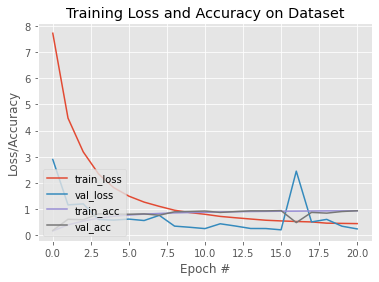

In [239]:
# plot the training loss and accuracy
N = np.arange(0, callback.stopped_epoch+1)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)

# Tester

## using .jpg and .txt from the YOLO Detection dataset to capture bounding boxes

In [240]:
# import the necessary packages
from tensorflow.keras.models import load_model
from skimage import transform
from skimage import exposure
from skimage import io
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [241]:
#function to plot an image
def plot_img(image, label,size=[6.4,4.8]):
    plt.figure(figsize=size)
    plt.axis(False)
    plt.title(label)
    plt.imshow(image)
    return

In [242]:
#function to crop the box from the input image
def crop_box(image,line):
    
    #split the line
    box = [float(i) for i in line.split()]
    h, w = image.shape[:2]
    
    #need to multiply with width/height since bounding boxes are in percentage
    x_center, y_center = (box[1] * w), (box[2] * h)
    box_width, box_height = (box[3] * w), (box[4] * h)
    x_min, y_min = (x_center - box_width/2), (y_center - box_height/2)
    
    #cropping region of interest
    roi = image[int(y_min):int(y_min+box_height), int(x_min):int(x_min+box_width)]
    
    return roi, [x_min, y_min,box_width, box_height]

In [243]:
#function to predict label for each input box

def predict_label(model, roi):
        
    # load the label names
    labelNames = open("signnames.csv").read().strip().split("\n")[1:]
    labelNames = [l.split(",")[1] for l in labelNames]
    
    #predict
    image = transform.resize(roi, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    
    # preprocess the image by scaling it to the range [0, 1]
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    
    # make predictions
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = labelNames[j]
    
    return label

In [244]:
#function to draw boxes and labels on the first input image

def detected_image(image_path, bbs, labels):
    image = io.imread(image_path)
    for box,label in zip(bbs,labels):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), [172 , 10, 127], 2)
        cv2.putText(image, label, (int(box[0] + box[2]), int(box[1] + box[3])), cv2.FONT_HERSHEY_SIMPLEX,0.45, (0, 0, 255), 2)
        
    return image

In [245]:
#single entry prediction function
def prediction(model_name, image_path,output_path):
    print("[INFO] loading model...")
    model = load_model(model_name)
    
    print("[INFO] predicting...")
    input_image = io.imread(image_path)

    plot_img(input_image, image_path.split("\\")[-1],[12,9])

    #since YOLO dataset has similar naming structure
    txt_path = image_path[:-3]+"txt"
    boxes=[]
    labels = []
    with open (txt_path, "r+") as f:
        for line in f:
            roi, box = crop_box(input_image,line)
            boxes.append(box)

            label = predict_label(model, roi)
            labels.append(label)

            plot_img(roi, label,[3,3])
        
    image = detected_image(image_path, boxes, labels)    
    plot_img(image, "final", [16,12])
    
    #save in an output folder
    io.imsave(os.path.join(output_path,image_path.split("\\")[-1]),image)
    
    return

### For single use case

In [255]:
image_path = "D:\\GTSRB Dataset\\gtsrb\\test_input\\00894.jpg"
output_path = "D:\\GTSRB Dataset\\gtsrb\\test_output"
model_name = "./trafficsignnet.model"

[INFO] loading model...
[INFO] predicting...


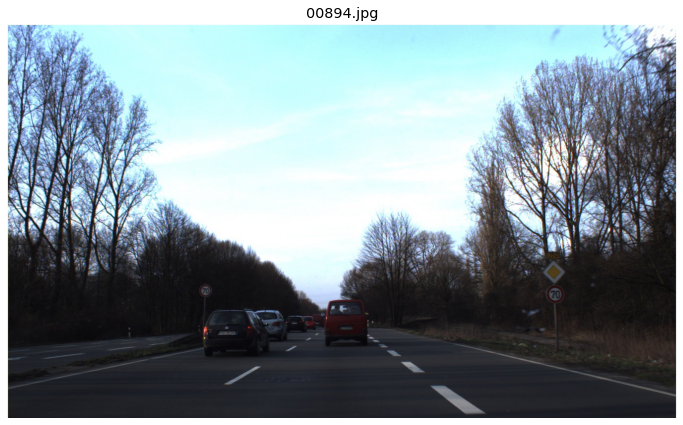

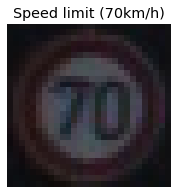

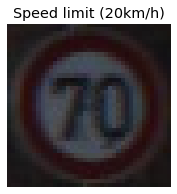

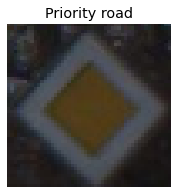

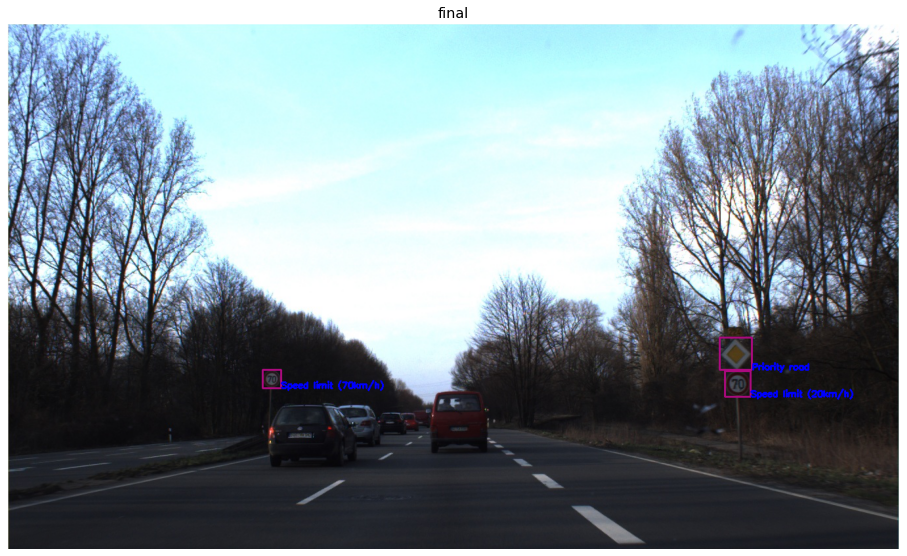

In [256]:
prediction(model_name, image_path,output_path)

### For folder

In [253]:
image_paths = list(paths.list_images("D:\GTSRB Dataset\gtsrb\\test_input"))
output_path = "D:\\GTSRB Dataset\\gtsrb\\test_output"
model_path = "D:\\GTSRB Dataset\\gtsrb\\trafficsignnet.model"

In [ ]:
#not the best method. check warnings

for image_path in image_paths:
    prediction(model_path,image_path,output_path)

# Tester to load YOLO model and run detection and classification

In [264]:
# import the necessary packages
from tensorflow.keras.models import load_model
from skimage import transform
from skimage import exposure
from skimage import io
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [265]:
#function to plot an image
def plot_img(image, label,size=[6.4,4.8]):
    plt.figure(figsize=size)
    plt.axis(False)
    plt.title(label)
    plt.imshow(image)
    return

In [266]:
#function to predict label for each input box

def predict_label(model, roi):
        
    # load the label names
    labelNames = open("signnames.csv").read().strip().split("\n")[1:]
    labelNames = [l.split(",")[1] for l in labelNames]
    
    #predict
    image = transform.resize(roi, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    
    # preprocess the image by scaling it to the range [0, 1]
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    
    # make predictions
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = labelNames[j]
    
    return label

In [267]:
#function to draw boxes and labels on the first input image

def detected_image(image_path, bbs, labels):
    image = io.imread(image_path)
    for box,label in zip(bbs,labels):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), [172 , 10, 127], 2)
        cv2.putText(image, label, (int(box[0] + box[2]), int(box[1] + box[3])), cv2.FONT_HERSHEY_SIMPLEX,0.45, (0, 0, 255), 2)
        
    return image

In [268]:
#function to crop box
def crop_roi(image,box):
    h, w = image.shape[:2]
    x_center, y_center = (box[0] * w), (box[1] * h)
    box_width, box_height = (box[2] * w), (box[3] * h)
    x_min, y_min = (x_center - box_width/2), (y_center - box_height/2)
    roi = image[int(y_min):int(y_min+box_height), int(x_min):int(x_min+box_width)]
    return roi, [x_min, y_min,box_width, box_height]

In [269]:


# net = cv2.dnn.readNet("yolov4-tiny_training_final.weights", "yolov4-tiny_training.cfg")
# layer_names = net.getLayerNames()
# output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# print(output_layers)
# confidence_threshold = 0.5

In [270]:
# blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
# net.setInput(blob)
# outs = net.forward(output_layers)
# print(outs[0][1])

In [271]:
image_path = "D:\\GTSRB Dataset\\gtsrb\\test_input\\00023.jpg"
output_path = "D:\\GTSRB Dataset\\gtsrb\\test_output"
model_name = "./trafficsignnet.model"

[INFO] loading model...


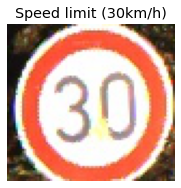

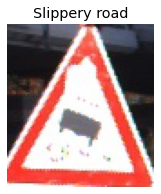

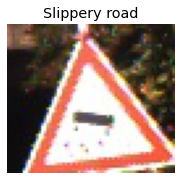

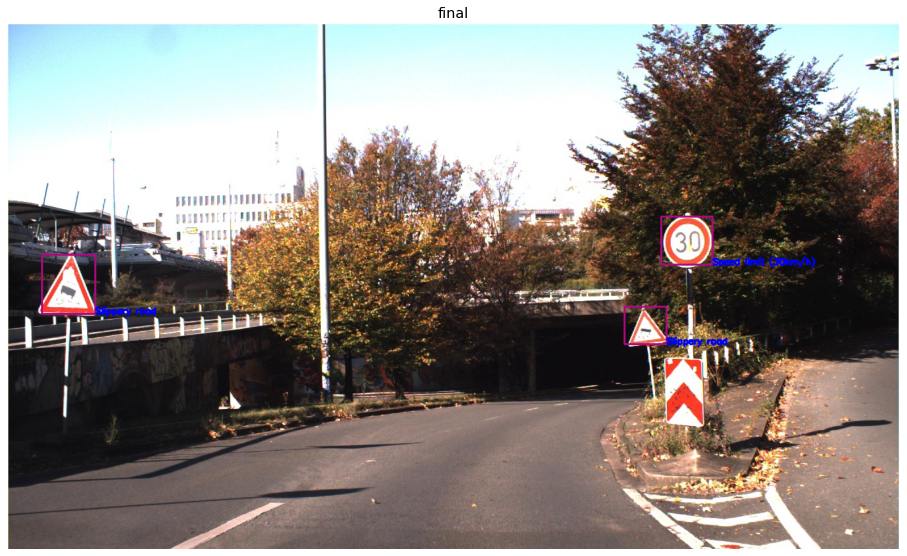

In [274]:
class_ids = []
confidences = []
boxes = []
rois = []
labels = []
bbs=[]

print("[INFO] loading model...")
model = load_model(model_name)

#yolo setup
net = cv2.dnn.readNet("yolov4-tiny_training_last_alz.weights", "yolov4-tiny_training.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# print(output_layers)
confidence_threshold = 0.5

#forward pass yolo
image = cv2.imread(image_path)
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

#reading again since classfier performing better on skimage
image = io.imread(image_path)

for out in outs:
    #     print(out.shape)
    for detection in out:
    #         print(len(detection))
        confidence = np.max(detection[5:])
        
        if confidence > confidence_threshold:
        #             print(confidence)
            roi, box = crop_roi(image,detection)
            confidences.append(float(confidence))
            rois.append(roi)
            boxes.append(box)

#adjust overlaps
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

for i,roi in enumerate(rois):
    if i in indexes:
        label = predict_label(model, roi)
        plot_img(roi, label,[3,3])
        labels.append(label)
        bbs.append(boxes[i])

# print(type(indexes[0]))
# label_np=np.array(labels)
# print(labels)
# print(indexes)
# print(len(bbs))
# print(label_np[indexes])

image = detected_image(image_path, bbs, labels)    
plot_img(image, "final", [16,12])
io.imsave(os.path.join(output_path,image_path.split("\\")[-1]),image)